# Structured hierarchical linear models

This project proposes a family of models, the *structured hierarchical linear model*, in order to incorporate biological prior knowledge into probabilistic models. The models can be easily described as:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\mathbf{y} \mid \boldsymbol \gamma & \sim \text{HM}(\mathbf{y} \mid \gamma)\\
\end{align}

The MRF is encoded as Potts-model. The HM can either be linear (this notebook) or nonlinear ([this notebook](./01b-hierarchical_nonlinear_model.ipynb)).

## SHMs for inferring pan-cellline essential genes

We apply our model to infer essential pan-cellline genes from CRISPR genes:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\tau^2_c & \sim \text{Inverse-Gamma}(2, 1) \\
\beta_{gc} \mid \gamma_g & \sim \mathcal{N}(\gamma_g, \tau_c^2) \\
l_{s} & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Half-Cauchy}(0, 3)\\
x_{gcs} \mid \beta_{cg}, l_s & \sim \mathcal{N}\left(l_{s} + o_s \cdot \beta_{cg}, \sigma^2 \right) \\
\end{align}

where we use $l_s$ as sgRNA correction factor and $o_s$ to model its binding affinity. Noise is expected to me homoscedastic. We compare the model against a model that does not have the clustering in the latent space and one that has a classical clustering model on the latent space.

In [1]:
import shm
import numpy
import networkx
import matplotlib
import seaborn as sns
import pandas as pd
import pickle
import pymc3 as pm

In [2]:
import arviz as az
import shm.plot as sp
import matplotlib.pyplot as plt
import seaborn as sns
from shm.models.hlm import HLM

In [3]:
import os

In [4]:
from pymc3 import model_to_graphviz

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 3)

Populating the interactive namespace from numpy and matplotlib


In [6]:
sns.set_style(
  "white",
  {
      "xtick.bottom": True,
      "ytick.left": True,
      "axes.spines.top": False,
      "axes.spines.right": False,
  },
)

In [7]:
def read_graph(infile):
    with open(infile, "rb") as fh:
        G = pickle.load(fh)
    return G

In [8]:
suffix = "four_bad_sgrnas"

# Model evaluation

In [9]:
readout_file = "../data_raw/{}-simulated_data.tsv".format(suffix)
graph_file = "../data_raw/{}-graph.pickle".format(suffix)
data_file = "../data_raw/{}-data.pickle".format(suffix)

In [10]:
with open(data_file, "rb") as fh:    
    data = pickle.load(fh)

In [11]:
readout = pd.read_csv(readout_file, sep="\t")
G = read_graph(graph_file)

In [25]:
data["count_table"]

,gene,condition,intervention,replicate,gene_conditions,gamma,beta,affinity,l,readout
0,POLR1B,C0,S0,R0,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.001094
1,POLR1B,C0,S0,R1,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.091094
2,POLR1B,C0,S0,R2,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.006565
3,POLR1B,C0,S0,R3,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.231858
4,POLR1B,C0,S0,R4,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.188972
5,POLR1B,C0,S1,R0,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.008353
6,POLR1B,C0,S1,R1,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.084818
7,POLR1B,C0,S1,R2,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.103776
8,POLR1B,C0,S1,R3,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.098862
9,POLR1B,C0,S1,R4,POLR1B-C0,-0.837565,0.028559,0.1,0.0,-0.030728


/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


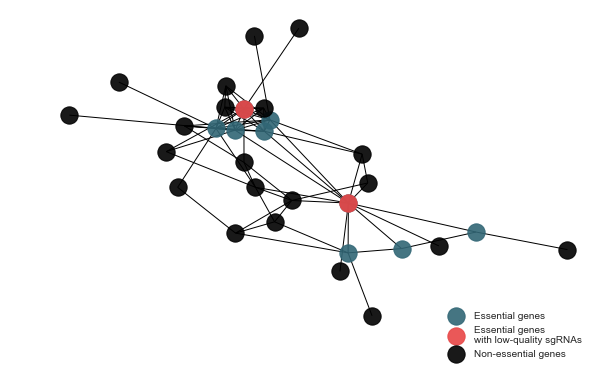

In [14]:
plt.figure(figsize=(10, 6))
pos = networkx.spring_layout(data["graph"])
networkx.draw_networkx_nodes(
  data["graph"], pos=pos,
  nodelist=list(data['essential_genes']), node_size=300,
  node_color='#316675', font_size=15, alpha=.9, label="Essential genes")
networkx.draw_networkx_nodes(
  data["graph"].subgraph(["PSMB1", "POLR1B"]), pos=pos,
  nodelist=list(["PSMB1", "POLR1B"]), node_size=300,
  node_color='#E84646', font_size=15, alpha=.9, 
    label="Essential genes\nwith low-quality sgRNAs")
networkx.draw_networkx_nodes(
  data["graph"], pos=pos,
  nodelist=list(data['nonessential_genes']), node_size=300,
  node_color='black', font_size=15, alpha=.9, label="Non-essential genes")
networkx.draw_networkx_edges(data["graph"], pos=pos)
plt.axis('off')
plt.legend(loc='center right', fancybox=False, framealpha=0, shadow=False,
           borderpad=1, bbox_to_anchor=(1, 0), ncol=1)

## Simple model

In [17]:
trace_dir = "../../../results/simple_model-{}_trace".format(suffix)
with HLM(readout, model="simple") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building simple hierarchical model
100%|██████████| 10000/10000 [00:07<00:00, 1362.74it/s]


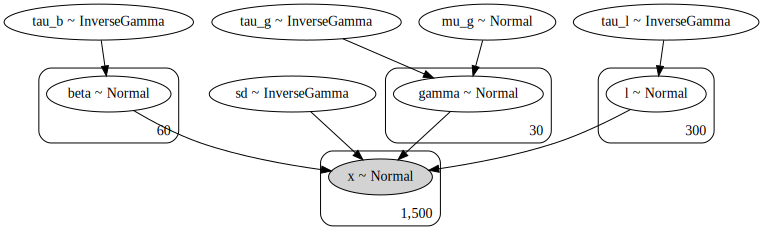

In [16]:
model_to_graphviz(model.model)

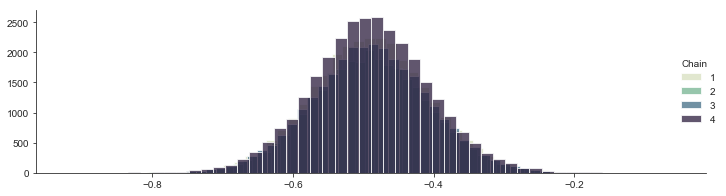

In [19]:
sp.plot_hist(trace, "gamma", 14, "");

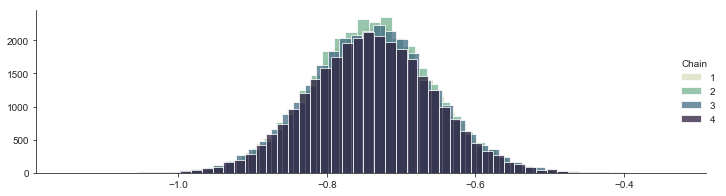

In [20]:
sp.plot_hist(trace, "gamma", 18, "");

In [21]:
data['genes']

array(['POLR1B', 'POLR2C', 'POLR2D', 'POLR3K', 'PSMB1', 'PSMC1', 'PSMC3',
       'PSMC5', 'PSMD4', 'MAP2K5', 'NIT2', 'RPL7A', 'PSMD7', 'ADRM1',
       'DDX19B', 'ERBB2', 'AHSA1', 'MRPL41', 'RPF1', 'ALDOART1',
       'HIST1H2BK', 'TAF15', 'RPL11', 'INSIG2', 'UBE2V1', 'RPS17',
       'GM8994', 'COX4I1', 'JAGN1', 'ITGA2'], dtype='<U9')

In [22]:
data['gamma'][[0, 4]]

array([-0.83756546, -0.91345924])

In [26]:
numpy.mean(trace['gamma'], 0)[[14, 18]]

array([-0.48996777, -0.73992565])

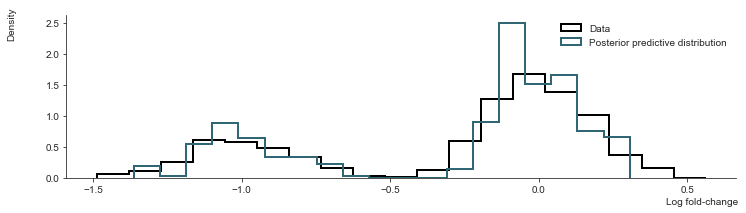

In [24]:
sp.plot_steps(readout, ppc_trace, bins=19);

## Clustering model

In [27]:
trace_dir = "../../../results/clustering_model-{}_trace".format(suffix)
with HLM(readout, model="clustering") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model
100%|██████████| 10000/10000 [00:07<00:00, 1341.70it/s]


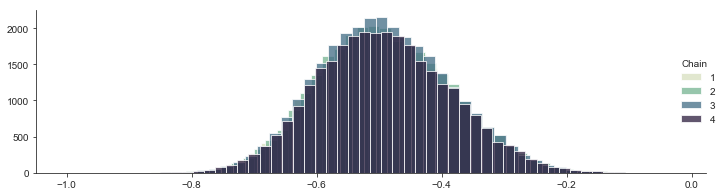

In [28]:
sp.plot_hist(trace, "gamma", 14, "");

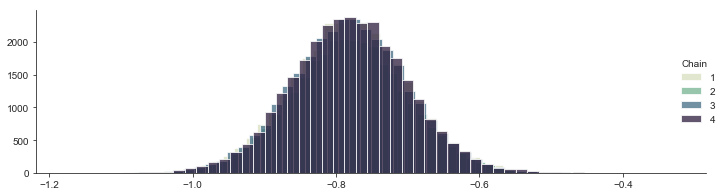

In [29]:
sp.plot_hist(trace, "gamma", 18, "");

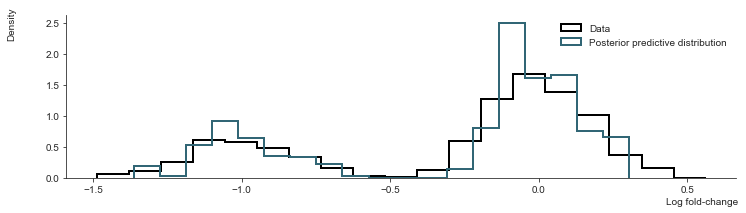

In [30]:
sp.plot_steps(readout, ppc_trace, bins=19);

In [31]:
data['gamma'][[0, 4]]

array([-0.83756546, -0.91345924])

In [32]:
numpy.mean(trace['gamma'], 0)[[14, 18]]

array([-0.49184879, -0.78132288])

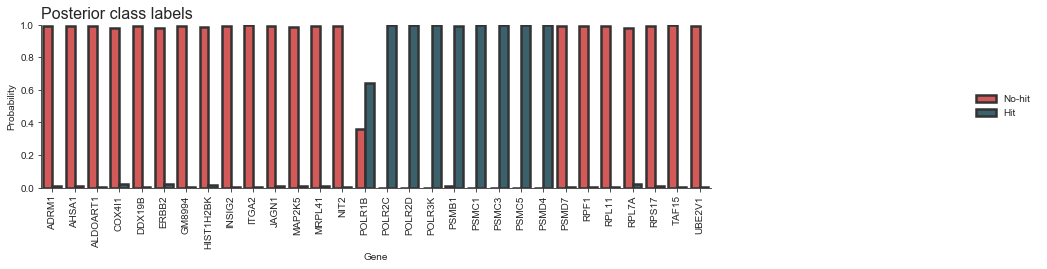

In [33]:
sp.plot_posterior_labels(
    trace, 
    [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

In [39]:
np.mean((readout["readout"].values - np.mean(ppc_trace['x'], 0))**2)

0.009970435901601044

## MRF model

In [12]:
trace_dir = "../../../results/mrf_model_trace"
with HLM(readout, model="mrf", graph=G) as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building mrf hierarchical model
100%|██████████| 10000/10000 [00:07<00:00, 1367.84it/s]


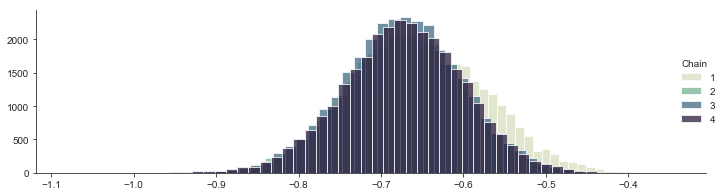

In [13]:
sp.plot_hist(trace, "gamma", 14, "");

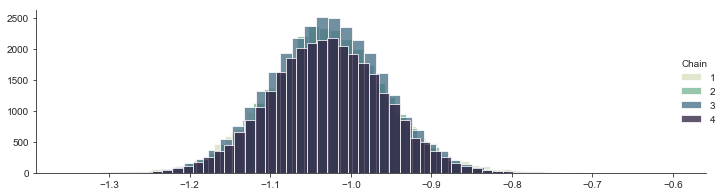

In [14]:
sp.plot_hist(trace, "gamma", 15, "");

In [16]:
data['gamma'][[0, 4]]

array([-0.83756546, -0.91345924])

In [17]:
numpy.mean(trace['gamma'], 0)[[14, 18]]

array([-0.66355273, -0.63526061])

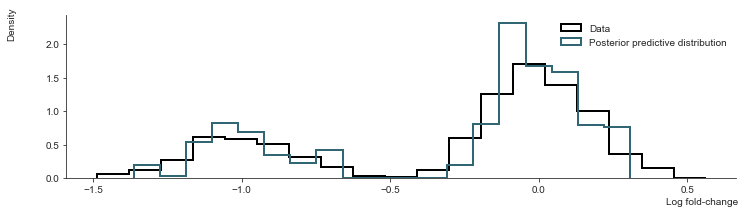

In [18]:
sp.plot_steps(readout, ppc_trace, bins=19);

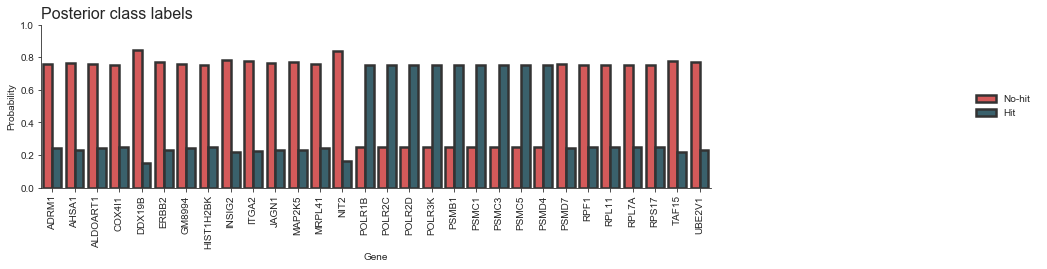

In [19]:
sp.plot_posterior_labels(
    trace,  [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

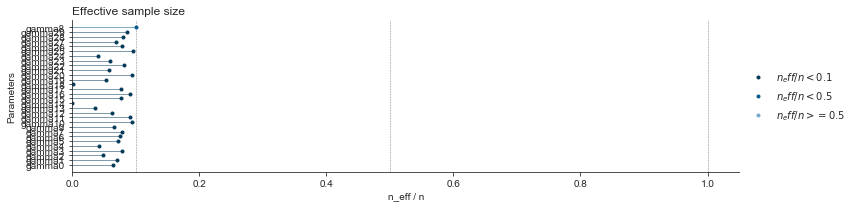

In [21]:
sp.plot_neff(trace, "gamma");

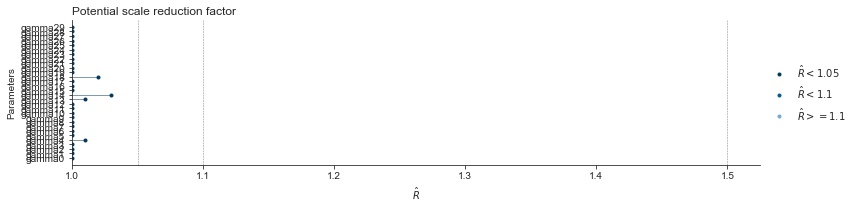

In [22]:
sp.plot_rhat(trace, "gamma");

In [29]:
np.mean((readout["readout"].values - np.mean(ppc_trace['x'], 0))**2)

0.008748406477614079